# Introduction

In this submission, dynamics of an aging population in the Netherlands is explored, utilizing a dataset from the Dutch Central Bureau of Statistics (CBS) which provides a detailed age and gender breakdown. The data from CBS's Population Pyramid visualizes shifts in the population structure, offering a profound insight into the demographic changes over recent years.

The objective of this visualization is to clearly highlight the aging trend within the Dutch population, with a particular focus on the disparities between male and female age distributions. Three groups are distinguised: 0-17 (youth), 18-65 (working force) and 65+ (elderly). As the data suggests, the elderly segment of the population is expanding, and this growth is more pronounced among women than men. This analysis aims to present these patterns through a series of graphs developed using the package plotnine.

This entry for the visualization contest seeks not only to showcase the technical capabilities of plotnine but also to provide a narrative on the demographic trends that are shaping the future of the Netherlands. By emphasizing the differences in aging between genders, societal and policy implications could be fostered.

## 1. Data loading

In [1]:
from plotnine import *
import pandas as pd
import os
import glob
import sklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create an empty list to store the dataframes
df_list = []

# Get the current working directory
cwd = os.getcwd()

# Change directory to the data folder
os.chdir(os.path.join(cwd, "data"))

# Get a list of all the csv files in the demo folder
csv_files = glob.glob("*.csv")

# Loop through the csv files and create a dataframe for each file
for file in csv_files:
    # Read the csv file into a dataframe
    df = pd.read_csv(file, delimiter=";")

    # Extract the year from the file name
    year = int(file[26:30])

    # Add the year as a separate column to the dataframe
    df["year"] = year

    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all the dataframes in the list into a single dataframe
df = pd.concat(df_list)

# Change directory back to the original working directory
os.chdir(cwd)

## Data cleaning

In [3]:
# Take only digits of age
df['Leeftijd'] = df['Leeftijd'].str.extract('(\d+)')

# Reset the index after dropping NaNs to avoid duplicate index values
df['Leeftijd'] = df['Leeftijd'].dropna().astype('int').reset_index(drop=True)

# Drop NaN values from the entire DataFrame
df = df.dropna()

df['Mannen'] = df['Mannen'].str.replace(' ', '').astype(int)
df['Vrouwen'] = df['Vrouwen'].str.replace(' ', '').astype(int)

# Bin age groups until the age of 17, from 18-65 and 65+
bins = [0, 18, 66, 105]
labels = ['0-17', '18-65', '65+']
df['Age group'] = pd.cut(df['Leeftijd'], bins, labels=labels)

# Aggregate data
df_grouped = df.groupby(['year', 'Age group']).sum()
df_grouped = df_grouped.groupby(['year', 'Age group']).agg(
    total_men=pd.NamedAgg(column='Mannen', aggfunc='sum'),
    total_women=pd.NamedAgg(column='Vrouwen', aggfunc='sum')
).reset_index()

# Change data type
df_grouped["year"] = df_grouped["year"].astype(int)

# Adding new column
df_grouped['total'] = df_grouped['total_men'] + df_grouped['total_women']


In [4]:
# Make column with grand totals of age groups
df_grouped['grand_total_men'] = df_grouped.groupby('year')['total_men'].transform(lambda x: 100 * x / x.sum())
df_grouped['grand_total_women'] = df_grouped.groupby('year')['total_women'].transform(lambda x: 100 * x / x.sum())
df_grouped['grand_total'] = df_grouped.groupby('year')['total'].transform(lambda x: 100 * x / x.sum())

In [5]:
# Melt data for plotnine
df_grouped_melt = df_grouped.melt(id_vars=["year", "Age group"],
                                  value_vars=["grand_total_men", "grand_total_women"],
                                  var_name="gender",
                                  value_name="percentage")

# Replace some column names
df_grouped_melt['gender'] = df_grouped_melt['gender'].replace({'grand_total_men': 'men', 'grand_total_women': 'women'})

In [6]:
df_grouped_melt.head()

,year,Age group,gender,percentage
0,1950,0-17,men,34.346130
1,1950,18-65,men,57.585711
2,1950,65+,men,8.068158
3,1960,0-17,men,35.526789
4,1960,18-65,men,55.807264


## 3. Some test plots

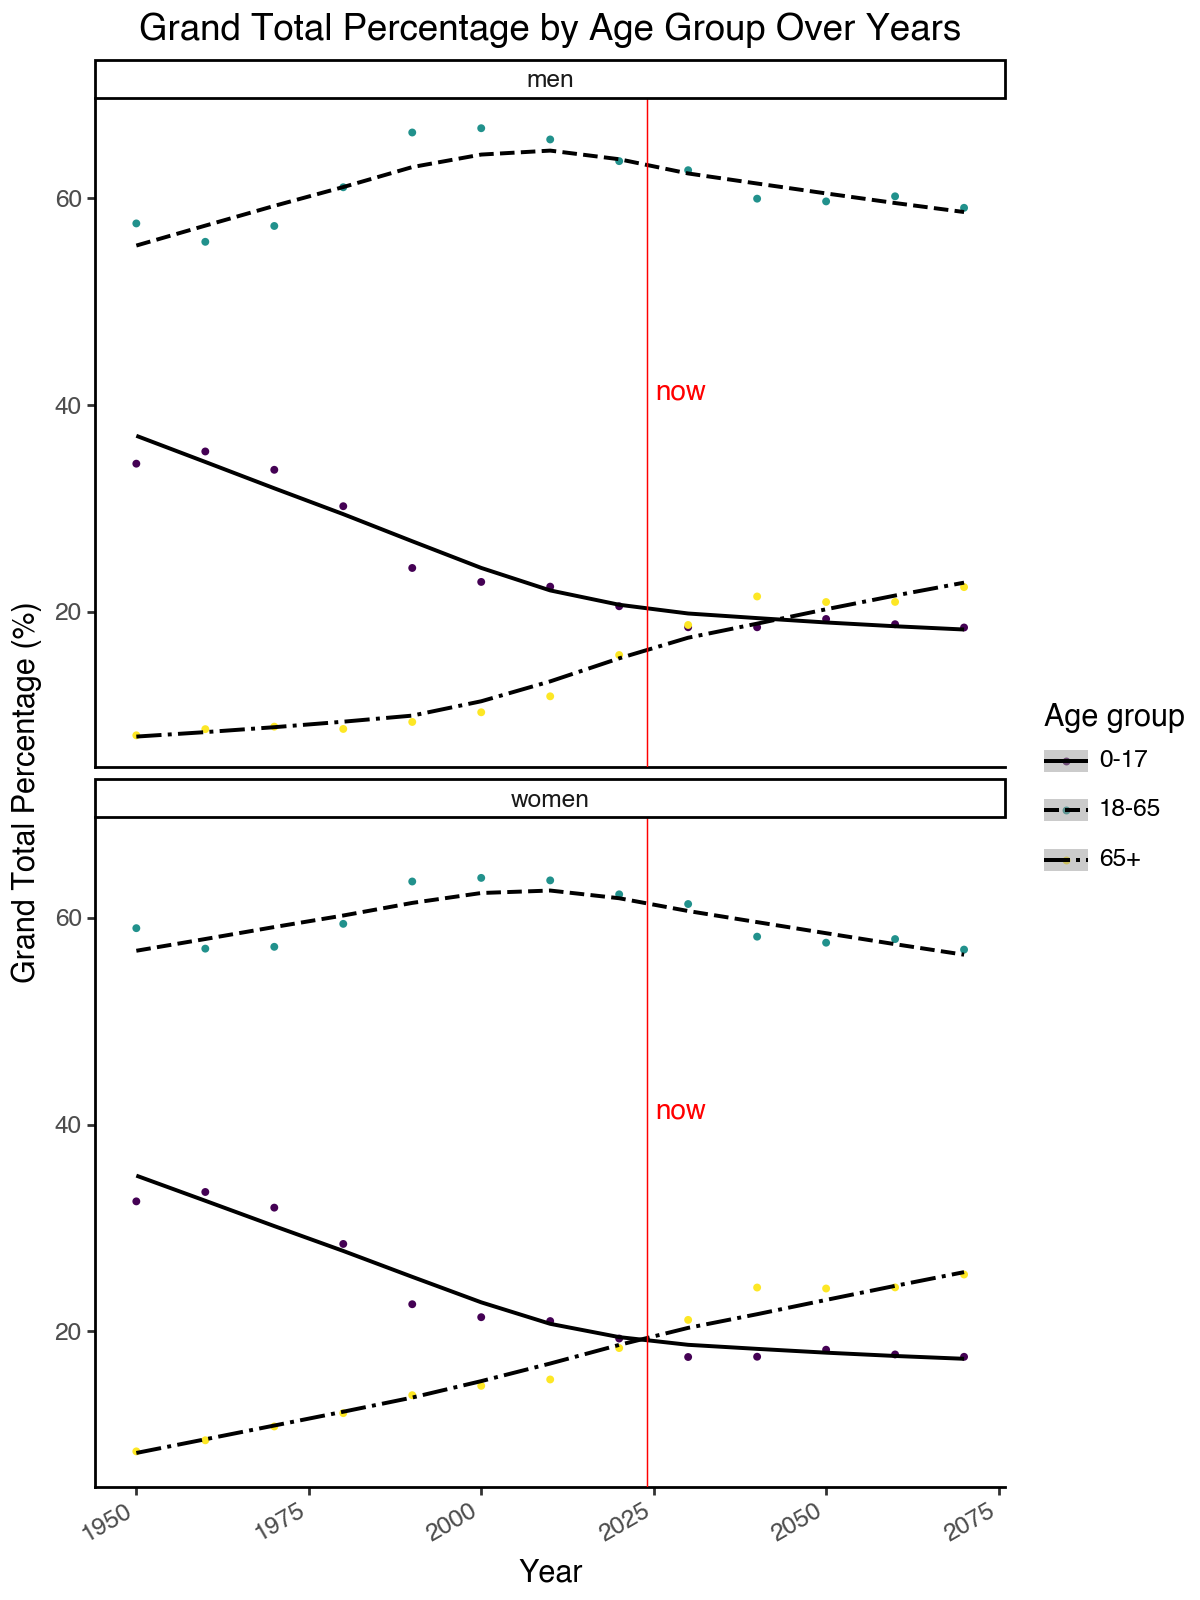

In [142]:
(
    ggplot(data=df_grouped_melt) +
    geom_point(mapping=aes(x="year", y="percentage", color="Age group"), size=0.6) +
    geom_smooth(mapping=aes(x="year", y="percentage", linetype="Age group"), size=0.8, alpha=0.5) +
    geom_vline(xintercept=2024, linetype="solid", color="red", size=0.3) +
    facet_wrap("gender", nrow=2) +
    annotate("text", x=2025, y=40, label="now", color="red", ha='left', va='bottom', size=10, nudge_x=0.2) +
        labs(
            title="Grand Total Percentage by Age Group Over Years",
            y="Grand Total Percentage (%)",
            x="Year"
        ) +\
        theme_classic() +
        theme(axis_text_x=element_text(angle=30, hjust=1), figure_size=(6, 8))
)

We could also look into an area plot, which is not picked as submission as the message is less clear.

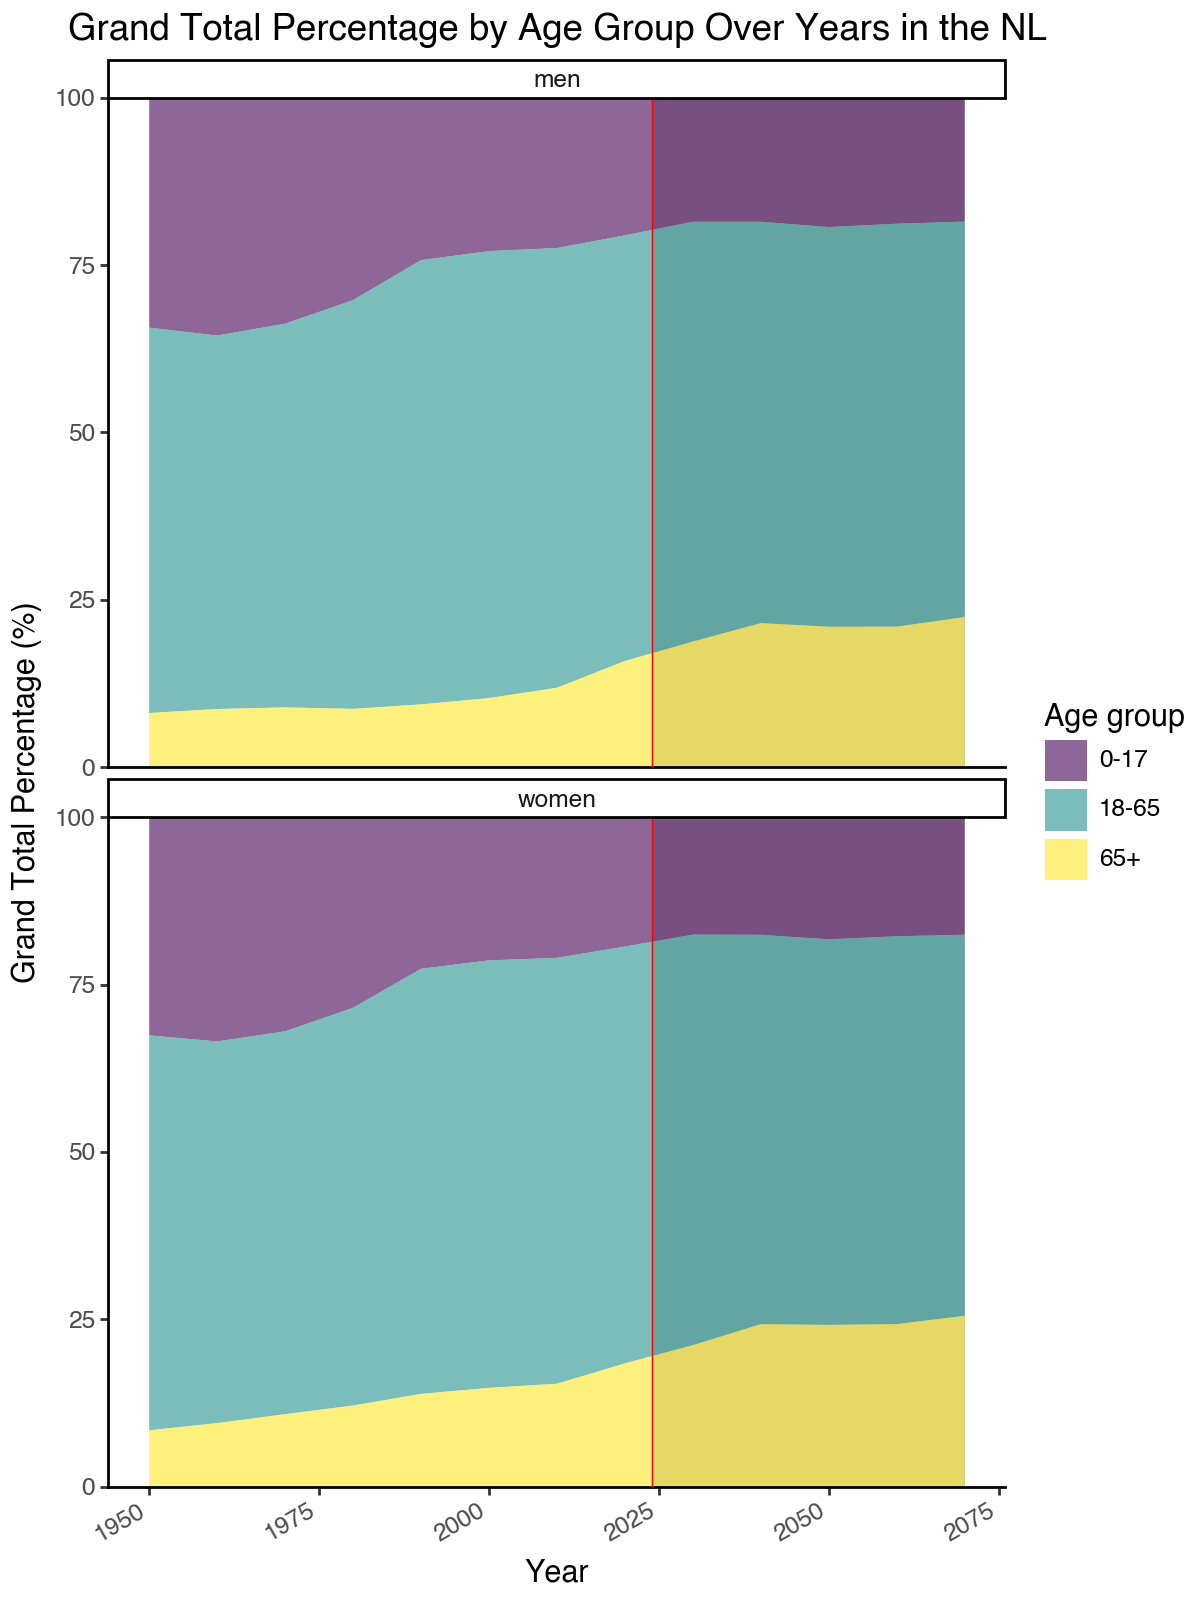

In [7]:
ggplot(data=df_grouped_melt) +\
geom_rect(aes(xmin=2024, xmax=max(df_grouped_melt['year']), ymin=0, ymax=100), fill='#595959', alpha=0.0059) +\
geom_area(aes(x="year", y="percentage", fill="Age group"), alpha=0.6) +\
facet_wrap("gender", nrow=2) +\
geom_vline(xintercept=2024, linetype="solid", color="red", size=0.3) +\
    labs(
        title="Grand Total Percentage by Age Group Over Years in the NL",
        y="Grand Total Percentage (%)",
        x="Year"
    ) +\
    theme_classic() +\
    theme(axis_text_x=element_text(angle=30, hjust=1), figure_size=(6, 8)) +\
    scale_y_continuous(expand=(0,0))

In [8]:
# Creating a new 'interaction' column for plot below
df_grouped_melt['Age group'] = df_grouped_melt['Age group'].astype(str)
df_grouped_melt['interaction'] = df_grouped_melt['Age group'] + '_' + df_grouped_melt['gender']

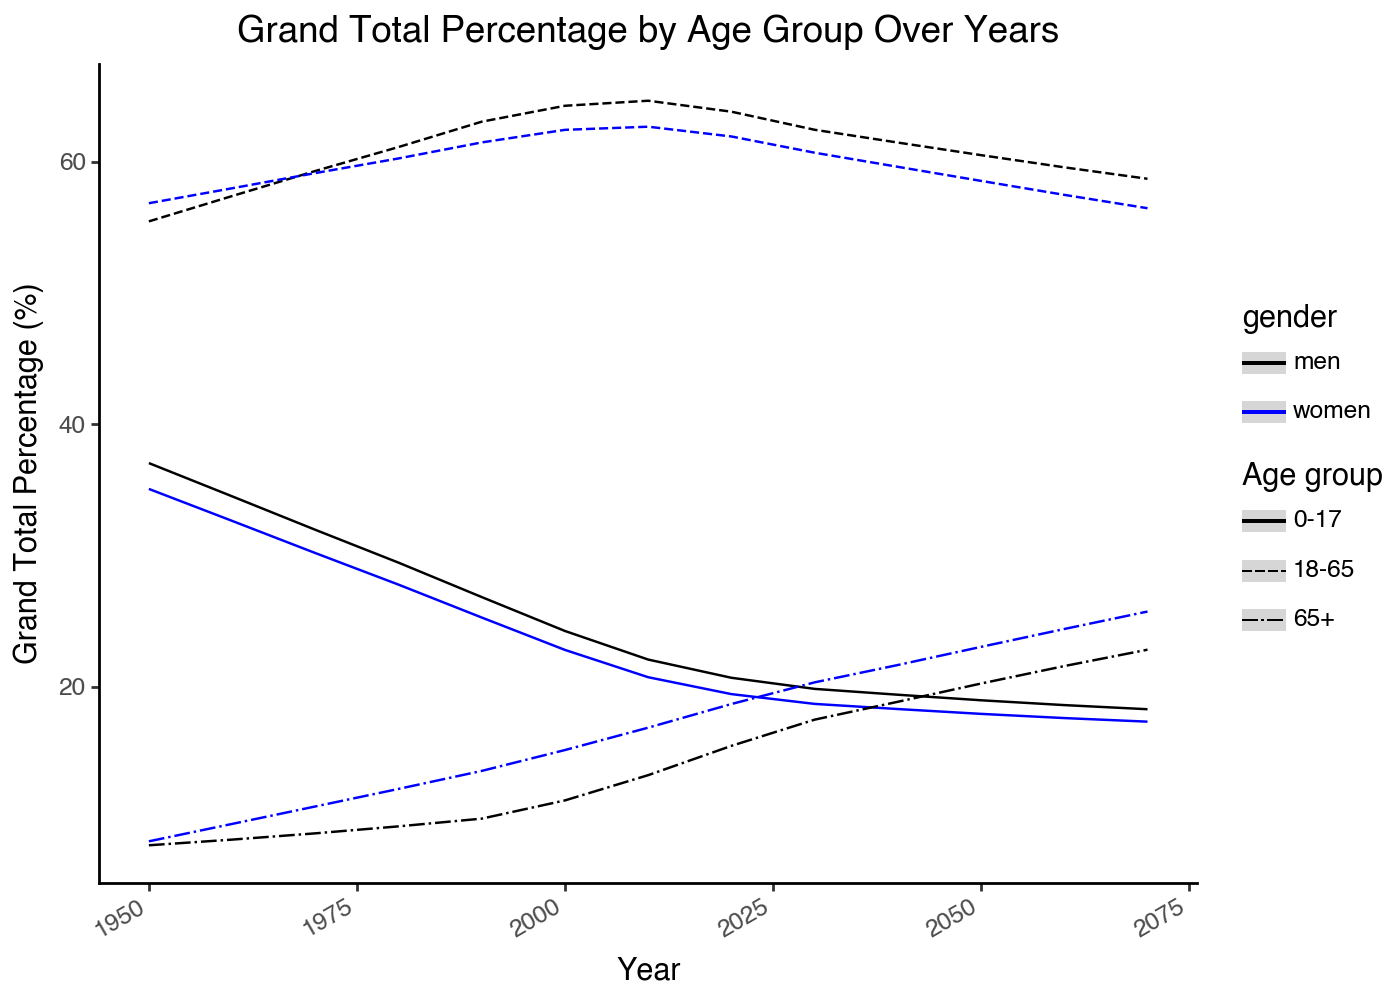

In [14]:
(
    ggplot(df_grouped_melt, aes(x='year', y='percentage', color='gender', linetype='Age group')) +
    geom_smooth(aes(group='interaction'), size=0.5) + # Use the new interaction column for grouping
    scale_color_manual(values={"men": "black", "women": "blue"}) +
        labs(
        title="Grand Total Percentage by Age Group Over Years",
        y="Grand Total Percentage (%)",
        x="Year"
    ) +\
    theme_classic() +\
    theme(axis_text_x=element_text(angle=30, hjust=1), figure_size=(7, 5))
    # xlim(2000, 2050)
    # geom_vline(xintercept=2024, linetype="solid", color="red", size=0.3)
    
)

## 4. Final plot

The submission plot emphasizes most clearly that for women in the Netherlands the amount of 65+ people is already bigger that the 0-17 group. For men, this point has not been reached yet. The plot could be powerful for policy makers.

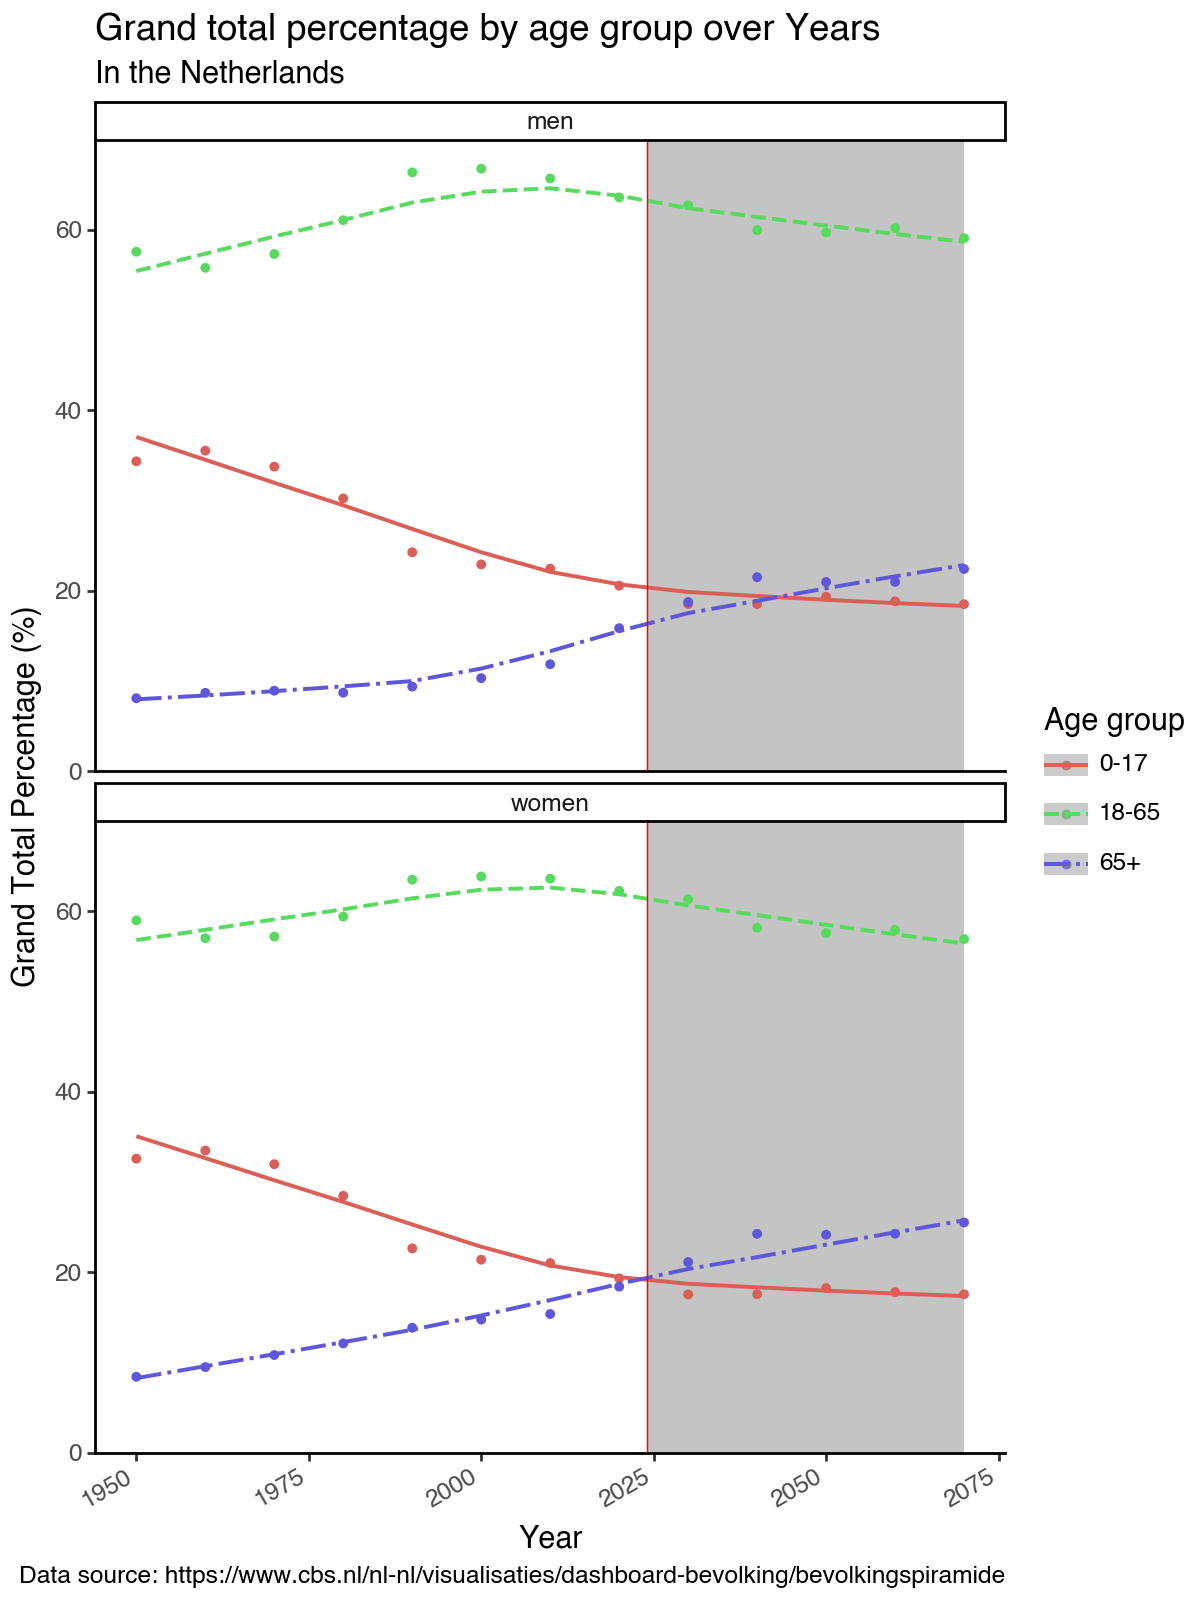

In [17]:
(
    ggplot(data=df_grouped_melt) +
    geom_rect(aes(xmin=2024, xmax=max(df_grouped_melt['year']), ymin=0, ymax=70), fill='#595959', alpha=0.0059) +
    geom_point(mapping=aes(x="year", y="percentage", color="Age group"), size=1) +
    geom_smooth(mapping=aes(x="year", y="percentage", linetype="Age group", color='Age group'), size=0.8, alpha=0.5) +
    facet_wrap("gender", nrow=2) +
    geom_vline(xintercept=2024, linetype="solid", color="red", size=0.3) +
        labs(
            title="Grand total percentage by age group over Years",
            subtitle='In the Netherlands',
            caption='Data source: https://www.cbs.nl/nl-nl/visualisaties/dashboard-bevolking/bevolkingspiramide',
            y="Grand Total Percentage (%)",
            x="Year"
        ) +
        theme_classic() +
        theme(axis_text_x=element_text(angle=30, hjust=1), figure_size=(6, 8)) +
        scale_y_continuous(expand=(0,0))
)

Another zoomed in version of the submission plot.

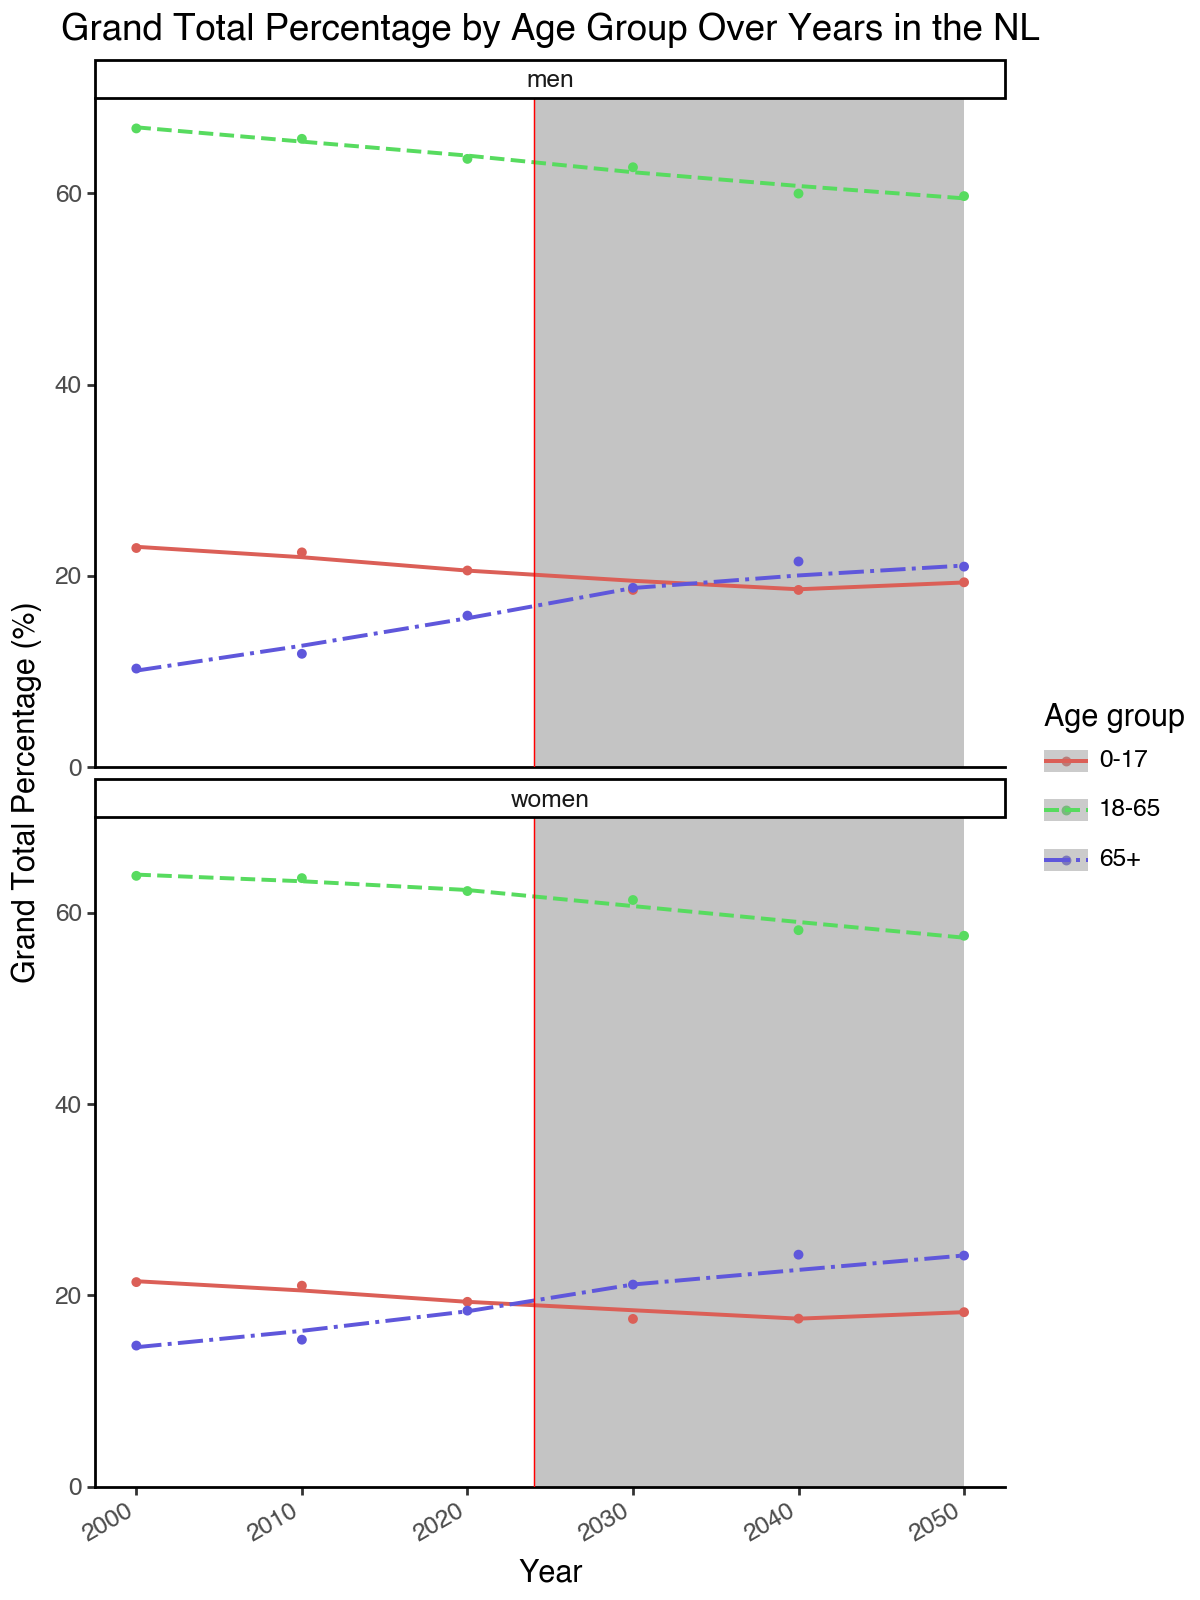

In [12]:
ggplot(data=df_grouped_melt) +\
geom_rect(aes(xmin=2024, xmax=2050, ymin=0, ymax=70), fill='#595959', alpha=0.0059) +\
geom_point(mapping=aes(x="year", y="percentage", color="Age group"), size=1) +\
geom_smooth(mapping=aes(x="year", y="percentage", linetype="Age group", color='Age group'), size=0.8, alpha=0.5) +\
facet_wrap("gender", nrow=2) +\
geom_vline(xintercept=2024, linetype="solid", color="red", size=0.3) +\
    labs(
        title="Grand Total Percentage by Age Group Over Years in the NL",
        y="Grand Total Percentage (%)",
        x="Year"
    ) +\
    theme_classic() +\
    theme(axis_text_x=element_text(angle=30, hjust=1), figure_size=(6, 8)) +\
    scale_y_continuous(expand=(0,0)) +\
    xlim(2000, 2050)